In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')     # стиль графиков

In [2]:
import numpy as np          # библиотека для матриц и математики
import pandas as pd         # библиотека для работы с табличками
from scipy  import stats    # библиотека для работы со статистикой

In [3]:
df = pd.read_csv('quotes.csv')

In [4]:
df['ctr'] = df.likes/df.views

<Axes: >

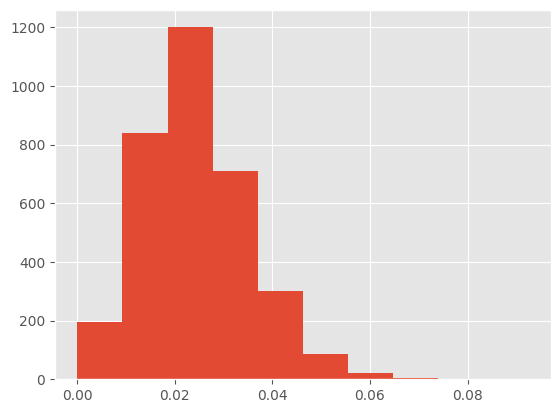

In [5]:
df.ctr.hist()

In [6]:
df.head()

,id,text,likes,date,views,ctr
0,10660,"""О, нет! Это что? Сессия?"" - подумал ты \n""Ну ...",9,1700308339,19145,0.000470
1,11259,П: Что-то мало людей на конференции\n- У меня ...,71,1715435332,1662,0.042720
2,11258,"Это будет долго, скучно, и самое главное, что ...",26,1715435321,1099,0.023658
3,11257,Анонсируем новый хакатон от SENSE и Акселерато...,0,1715421815,589,0.000000
4,11253,"Если гадость и могла случиться, то уже в старш...",87,1714990296,4722,0.018424


# Обработка данных

### Выделение тэга

In [7]:
import re

def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags

In [8]:
df.text = df.text.astype('str')
df['hashtags'] = df.text.apply(lambda z: extract_hashtags(z))

In [9]:
df['hashtags_len'] = df['hashtags'].apply(lambda z: len(z))

In [10]:
df.groupby(['hashtags_len']).count()[['id']]

,id
hashtags_len,
0,147
1,3191
2,13
3,2
5,1
6,1
10,3
14,1
16,1


In [11]:
df['hashtags_with_empty'] = df.hashtags.apply(lambda z: z + ['#empty'])

In [12]:
df['first_hashtag'] = df.hashtags_with_empty.apply(lambda z: z[0])

In [13]:
df.groupby('first_hashtag').count().sort_values(by = 'id', ascending=False).head(10)

,id,text,likes,date,views,ctr,hashtags,hashtags_len,hashtags_with_empty
first_hashtag,,,,,,,,,
#empty,147,147,147,147,147,147,147,147,147
#Ершов_mipt,100,100,100,100,100,100,100,100,100
#Дымарский_mipt,82,82,82,82,82,82,82,82,82
#Овчинкин_mipt,78,78,78,78,78,78,78,78,78
#Бурмистров_mipt,77,77,77,77,77,77,77,77,77
#Колдунов_mipt,63,63,63,63,63,63,63,63,63
#Огарков_mipt,60,60,60,60,60,60,60,60,60
#Райгородский_mipt,59,59,59,59,59,59,59,59,59
#Давтян_mipt,56,56,56,56,56,56,56,56,56


In [14]:
# популярные тэги

all_tags = df.groupby('first_hashtag', as_index=False).count().sort_values(by = 'id', ascending=False)

In [15]:
popular_tags = list(all_tags[all_tags.id >= 10]['first_hashtag'])

In [16]:
len(popular_tags)

84

In [17]:
# Вместо тэга оставим порядковый номер

popular_tags_dict = {}
i = 0
for item in popular_tags:
    popular_tags_dict[item] = i
    i+=1

In [18]:
df['first_hashtag_number'] = df['first_hashtag'].apply(lambda z: popular_tags_dict[z]\
                                                       if z in popular_tags_dict else -1)

### Уберем тэги из текста

In [19]:
def remove_hashtags(text):
    # Удаление всех слов, начинающихся на '#'
    return re.sub(r'#\w+', '', text)

In [20]:
df.text = df.text.apply(lambda z: remove_hashtags(z))

### Итоговый датафрейм

In [21]:
df = df[['id', 'text', 'likes', 'date', 'ctr', 'first_hashtag_number']]

In [22]:
df.head()

,id,text,likes,date,ctr,first_hashtag_number
0,10660,"""О, нет! Это что? Сессия?"" - подумал ты \n""Ну ...",9,1700308339,0.000470,-1
1,11259,П: Что-то мало людей на конференции\n- У меня ...,71,1715435332,0.042720,-1
2,11258,"Это будет долго, скучно, и самое главное, что ...",26,1715435321,0.023658,-1
3,11257,Анонсируем новый хакатон от SENSE и Акселерато...,0,1715421815,0.000000,0
4,11253,"Если гадость и могла случиться, то уже в старш...",87,1714990296,0.018424,-1


In [23]:
df.first_hashtag_number = df.first_hashtag_number.apply(lambda z: z+1)

In [24]:
df.first_hashtag_number.max()

84

# Train & Test

In [25]:
from sklearn.model_selection import train_test_split
train_cut, test_cut = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
train_cut.head()

,id,text,likes,date,ctr,first_hashtag_number
3086,704,СИ - отстой\n\n,112,1508404732,0.032156,36
2698,1800,"Будь мужиком , считай интеграл целиком!\n",153,1518262835,0.036059,55
1684,5170,nan,1,1572598809,0.000260,1
1992,4102,- как тесты влияют на оценку?\n- как тесты на ...,134,1550317868,0.026645,0
2653,1919,Решил задачу - прочитай условие.\n,267,1519121346,0.031877,82


In [27]:
len(train_cut), len(test_cut)

(2688, 672)

In [30]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output



class Trainer:
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adam(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        self.loss_fn = nn.MSELoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)

    def fit(self, model, train_dataloader, val_dataloader):
        
        print("to device")
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        print("create opt")
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        print("start?")

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
            clear_output()
            plt.yscale('log')
            plt.plot(np.linspace(0, epoch + 1, len(self.history['train_loss'])), self.history['train_loss'], label='train_loss')
            plt.plot(np.linspace(0, epoch + 1, len(self.history['val_loss'])), self.history['val_loss'], label='val_loss')
            plt.plot(np.linspace(0, epoch + 1, len(self.history['val_acc'])), self.history['val_acc'], label='val_mse')
            plt.legend()
            plt.show()
        return self.model.eval()

    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            tags = batch['tags'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.float)

            outputs = self.model(ids, mask, tags)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
            #print(outputs.shape, targets.shape)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                tags = batch['tags'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.float)
                outputs = self.model(ids, mask, tags)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = mean_squared_error(all_logits.detach().cpu(), all_labels.detach().cpu())
        print(f"val_mse={acc}")
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                tags = batch['tags'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask, tags)
                predictions.extend(outputs.tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

# Трансформер

In [31]:
import torch
from torch.utils.data import Dataset


class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['text'].tolist()
        self.tags = dataframe['first_hashtag_number'].tolist()
        self.targets = None
        if 'ctr' in dataframe:
            self.targets = dataframe['ctr'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        tags = self.tags[index]

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'tags': torch.tensor(tags, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'tags': torch.tensor(tags, dtype=torch.long)
            }

    def __len__(self) -> int:
        return len(self.text)

In [32]:
from typing import Dict

import torch
from transformers import AutoModel


class ModelForRegression(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForRegression, self).__init__()
        self.model_name = model_path
        self.config = config
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.tags_prep = torch.nn.Embedding(85, 64)
        self.pre_regressor = torch.nn.Linear(832, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.regressor = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, tags):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = torch.cat([hidden_state, self.tags_prep(tags)], dim=-1)
        hidden_state = self.pre_regressor(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.regressor(hidden_state)
        return output[:, 0]

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [33]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

In [34]:
# Токенизируем слова
tokenizer = AutoTokenizer.from_pretrained(
    "DeepPavlov/rubert-base-cased", truncation=True, do_lower_case=True)

In [35]:
MAX_LEN = 128
BATCH_SIZE = 64

In [36]:
train_dataset = FiveDataset(train_cut, tokenizer, MAX_LEN)
val_dataset = FiveDataset(test_cut, tokenizer, MAX_LEN)

In [37]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 4
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 4
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)

In [38]:
tokenizer.decode(next(iter(train_dataloader))['ids'][63])

'[CLS] вы в школе учились? нет. вы не учились — вы отсидели. а выпустили вас за хорошее поведение. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [39]:
next(iter(train_dataloader))

{'ids': tensor([[  101, 19030,  8235,  ...,     0,     0,     0],
         [  101,  7974, 85291,  ...,     0,     0,     0],
         [  101,   625,  2739,  ...,     0,     0,     0],
         ...,
         [  101, 26998,   128,  ...,     0,     0,     0],
         [  101,   130,   845,  ...,     0,     0,     0],
         [  101,   120, 22293,  ...,     0,     0,     0]]),
 'tags': tensor([22, 18, 12,  3,  0, 14, 48, 12, 46, 28, 48, 15, 60,  1, 74,  4, 27, 47,
         62,  0,  0, 51,  0, 14, 65, 13, 17,  0,  0,  3,  0, 23,  0,  0,  3, 33,
          0,  0,  8,  0, 58,  0,  0,  6,  0,  2, 62,  0,  0,  0, 31,  0,  0,  0,
          0,  0,  8, 22,  5,  5,  0,  0, 84, 24]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([0.0296, 0.0294, 0.0338, 0.0221, 0.0276, 0.0288, 0.0147, 0.0353, 0.0

In [40]:
config = {
    "dropout_rate": 0.5
}
model = ModelForRegression(
    "DeepPavlov/rubert-base-cased",
    config=config
)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

In [41]:
model.to('cuda')

ModelForRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [42]:
# for p in model.bert.parameters():
#     p.requires_grad = False

In [43]:
trainer_config = {
    "lr": 1e-5,
    "n_epochs": 100,
    "weight_decay": 1e-5,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config)

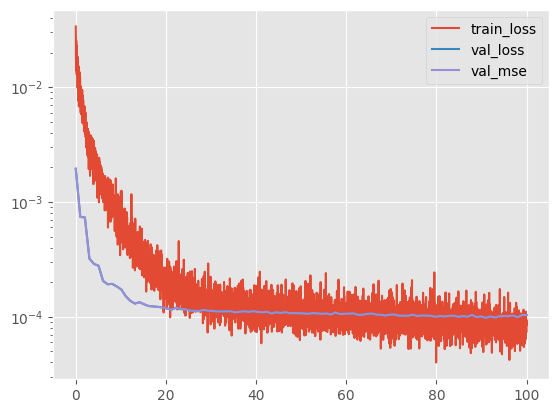

In [44]:
history = t.fit(
  model,
  train_dataloader,
  val_dataloader
)

In [45]:
model.eval()

ModelForRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [46]:
predictions = t.predict(val_dataloader)

In [47]:
from sklearn.metrics import mean_squared_error

# Calculation of Mean Squared Error (MSE)
mean_squared_error(test_cut['ctr'], predictions)

0.00010370908890686594

In [48]:
test_cut['predictions'] = predictions

Text(0, 0.5, 'prediction')

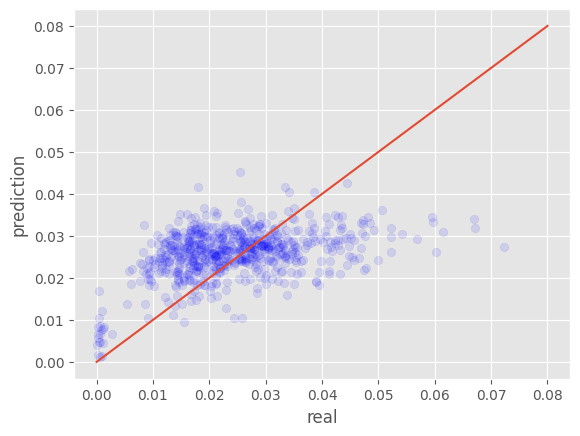

In [49]:
plt.scatter(test_cut.ctr, test_cut.predictions, alpha=0.1, color = 'blue')
plt.plot(np.linspace(0,0.08,100), np.linspace(0,0.08,100))
plt.xlabel('real')
plt.ylabel('prediction')

# Линейная регрессия (Baseline)

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
train_cut.head()

,id,text,likes,date,ctr,first_hashtag_number
3086,704,СИ - отстой\n\n,112,1508404732,0.032156,36
2698,1800,"Будь мужиком , считай интеграл целиком!\n",153,1518262835,0.036059,55
1684,5170,nan,1,1572598809,0.000260,1
1992,4102,- как тесты влияют на оценку?\n- как тесты на ...,134,1550317868,0.026645,0
2653,1919,Решил задачу - прочитай условие.\n,267,1519121346,0.031877,82


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import numpy as np
import nltk
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from sklearn.metrics import f1_score
stopwords = nltk.corpus.stopwords.words("russian")

# Init tf-idf
vect_word = TfidfVectorizer(
    max_features=1000,
    lowercase=True,
    analyzer="word",
    stop_words=stopwords,
    ngram_range=(1, 5),
    dtype=np.float32
)

In [38]:
# Train tf-idf
X_train = vect_word.fit_transform(train_cut["text"])
# Map tf-idf on test
X_test = vect_word.transform(test_cut["text"])
y_train = train_cut["ctr"]

In [45]:
# Init logreg model
lreg = LinearRegression()

In [46]:
# Train logreg
lreg.fit(X_train, y_train)

LinearRegression()

In [59]:
# Predict probabilities
preds = lreg.predict(X_test)

In [60]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_cut['ctr'], preds)

0.0001784218193861955